# Postprocessing
This notebook summarizes performance metrics of a trained GCN model. It especially plots:
* ROC/PR curves
* The relationship of predictions and node degree
* The overlap of predictions and database cancer genes

In [10]:
import numpy as np
import pandas as pd
import gcnIO, postprocessing
import sys, os

# set options
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
model_dir = '../data/GCN/training/2019_04_26_15_21_21/mutations/'

args, data_file = gcnIO.load_hyper_params(model_dir)
if os.path.isdir(data_file):
    fname = 'IREF_{}.h5'.format(model_dir.strip('/').split('/')[-1])
    data_file = os.path.join(data_file, fname)
data = gcnIO.load_hdf_data(data_file)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
print ("Data comes from {}".format(data_file))
print (args)
CLASSIFICATION_THRESHOLD = 0.5


Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt
Data comes from ../data/pancancer/multiomics_containers/IREF_mutations.h5
{'cv_runs': 10, 'loss_mul': 45.0, 'decay': 0.05, 'lr': 0.001, 'hidden_dims': [50, 100], 'dropout': 0.5, 'epochs': 5000, 'support': 1, 'data': '../data/pancancer/multiomics_containers/'}


## Predictions
I want to see what the GCN predicts and if those predictions make any sense.

Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt
Data comes from ../data/pancancer/multiomics_containers/IREF_mutations.h5
Read predictions from 10 CV runs
Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt
Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt


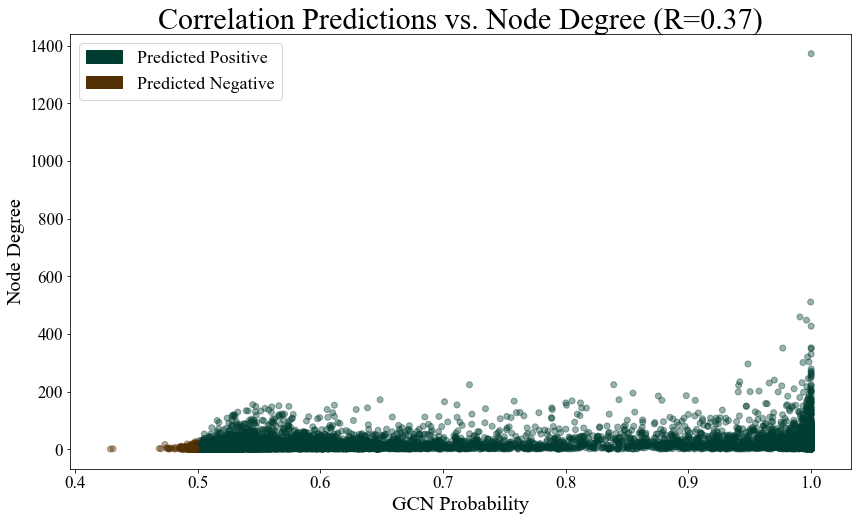

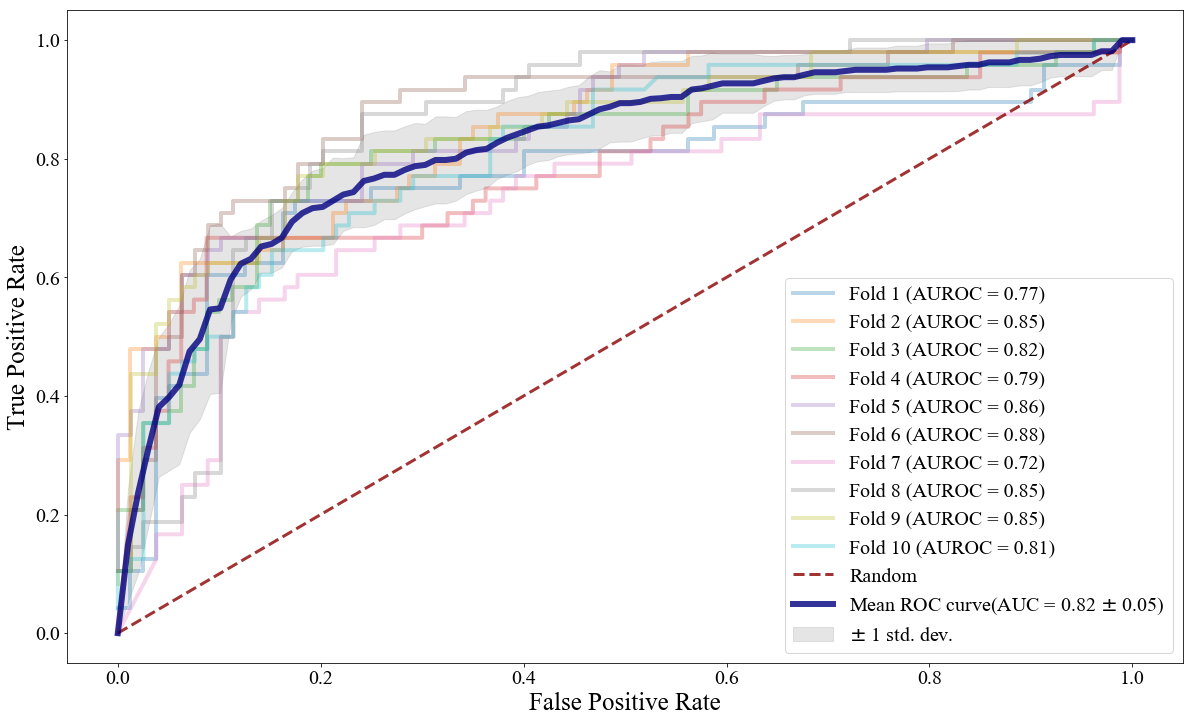

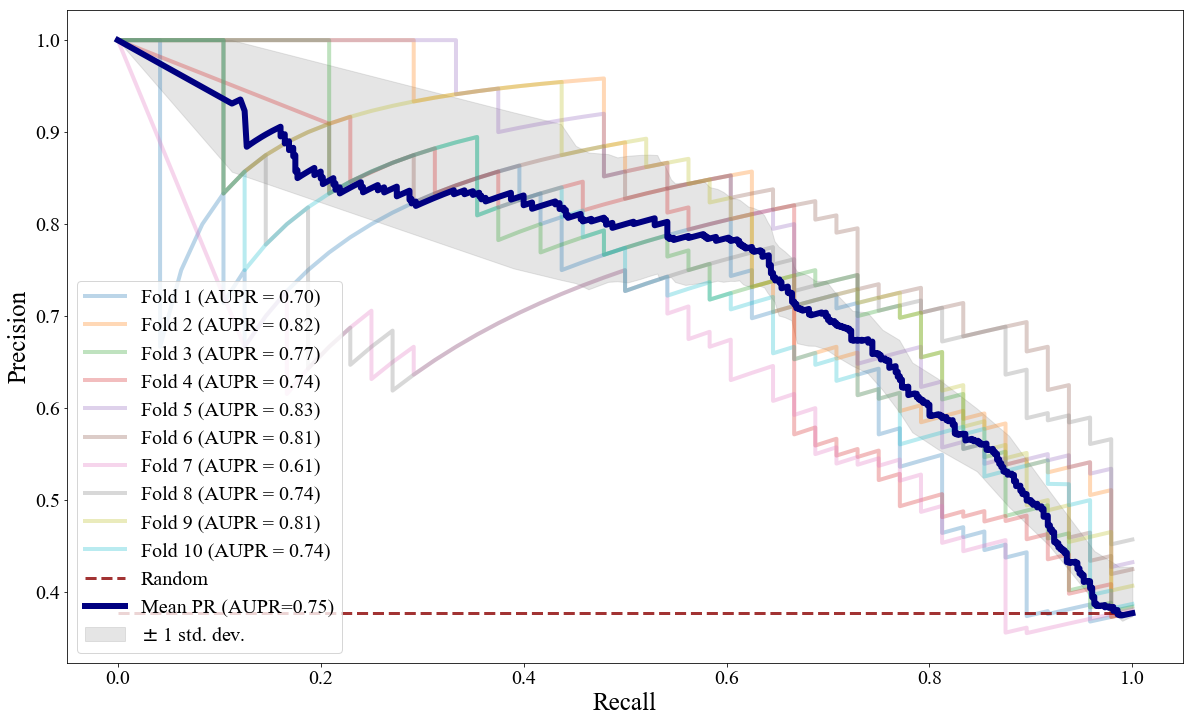

In [3]:
all_preds, all_sets = postprocessing.compute_ensemble_predictions(model_dir)
postprocessing.compute_node_degree_relation(model_dir, 0.5)
postprocessing.compute_average_ROC_curve(model_dir, all_preds, all_sets)
postprocessing.compute_average_PR_curve(model_dir, all_preds, all_sets)

In [4]:
predictions = pd.DataFrame.from_csv(os.path.join(model_dir, 'ensemble_predictions.tsv'),
                                    sep='\t', header=0)
nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
nodes = nodes[~nodes.index.duplicated()]
pred_ordered = predictions[~predictions.index.duplicated()]
pred_ordered.reindex(index=nodes.index)

predictions.drop([c for c in predictions.columns if c.startswith('Prob_pos')], axis=1, inplace=True)
predictions.columns = ['Name', 'label', 'Num_Pos', 'Prob_pos', 'Std_Pred']

## Enrich predictions and plot relationship to node degree

In [7]:
features_df = pd.DataFrame(features, index=node_names[:, 0])
features_df['Name'] = node_names[:, 1]
features_df['neighbors'] = network.sum(axis=0)
pred_with_feat = features_df.join(predictions, how='inner', lsuffix='_')
pos_predicted = pred_with_feat[pred_with_feat.Prob_pos > CLASSIFICATION_THRESHOLD]

# add columns to distinguish between training and test set
labels_df = pd.DataFrame(node_names, index=node_names[:, 0], columns=['ID', 'Name']).drop(['ID'], axis=1)
labels_df['positive'] = (y_train[:,0] | y_test[:,0] | y_val[:, 0])
labels_df['training_set'] = train_mask
labels_df['testing_set'] = test_mask
labels_df['validation_set'] = val_mask
labels_df['label'] = np.logical_or(train_mask, test_mask, val_mask).astype(int)
labels_df['negative'] = labels_df.label & ~labels_df.positive

# show the ones that are most confidently predicted
print ("Predicted {} genes of {} total to be involved in infection".format(pos_predicted.shape[0], predictions.shape[0]))
pos_nofeat = predictions[predictions.Prob_pos >= CLASSIFICATION_THRESHOLD]
pos_nofeat.sort_values(by='Prob_pos', ascending=False).to_csv(os.path.join(model_dir, 'positive_prediction.txt'),
                                                                 sep='\t')

Predicted 9381 genes of 12129 total to be involved in infection


In [8]:
labels_with_pred = labels_df.join(predictions, lsuffix='_', how='inner')
predictions_for_pos = labels_with_pred[labels_with_pred.positive == 1]
true_positives = predictions_for_pos[predictions_for_pos.Prob_pos > CLASSIFICATION_THRESHOLD]
no_tp = true_positives.shape[0]
no_positives = predictions_for_pos.shape[0]
pred_pos_test = true_positives[true_positives.testing_set == 1]
pred_pos_train = true_positives[true_positives.training_set == 1]
predictions_for_neg = labels_with_pred[labels_with_pred.negative == 1]
true_negatives = predictions_for_neg[predictions_for_neg.Prob_pos <= CLASSIFICATION_THRESHOLD]
no_tn = true_negatives.shape[0]
no_fn = predictions_for_neg[predictions_for_neg.Prob_pos > CLASSIFICATION_THRESHOLD].shape[0]

print ("Predicted {} out of {} known infection genes".format(no_tp, no_positives)
      )
print ("Out of these {}, {} were not shown during training.".format(no_positives,
                                                                    y_test[:, 0].sum())
      )
print ("Predicted {} out of {} test genes ({}%)".format(pred_pos_test.shape[0],
                                                        y_test[:,0].sum(),
                                                        pred_pos_test.shape[0]/y_test[:,0].sum()*100.)
      )
print ("Predicted {} out of {} train genes ({}%)".format(pred_pos_train.shape[0],
                                                         y_train[:,0].sum(),
                                                         pred_pos_train.shape[0]/y_train[:,0].sum()*100.)
      )
print ("Correctly rejected {} out of {} genes (True Negatives) ({}%)".format(no_tn,
                                                                     predictions_for_neg.shape[0],
                                                                     no_tn/predictions_for_neg.shape[0]*100.))
print ("Falsely predicted {} negatives (FN)".format(no_fn))
predictions_for_neg.sort_values(by='Prob_pos', ascending=False).head(20)

Predicted 613 out of 637 known infection genes
Out of these 637, 160 were not shown during training.
Predicted 155 out of 160 test genes (96.875%)
Predicted 413 out of 432 train genes (95.60185185185185%)
Correctly rejected 193 out of 713 genes (True Negatives) (27.068723702664798%)
Falsely predicted 520 negatives (FN)


,Name_,positive,training_set,testing_set,validation_set,label_,negative,Name,label,Num_Pos,Prob_pos,Std_Pred
ENSG00000126264,HCST,False,True,False,True,1,True,HCST,False,10,1.000,0.000
ENSG00000110075,PPP6R3,False,False,True,True,1,True,PPP6R3,False,10,1.000,0.000
ENSG00000105963,ADAP1,False,True,False,True,1,True,ADAP1,False,10,1.000,0.000
ENSG00000149679,CABLES2,False,False,True,True,1,True,CABLES2,False,10,1.000,0.000
ENSG00000159445,THEM4,False,True,False,True,1,True,THEM4,False,10,1.000,0.000
ENSG00000226103,C6orf47,False,True,False,True,1,True,C6orf47,False,10,1.000,0.000
ENSG00000138660,AP1AR,False,True,False,True,1,True,AP1AR,False,10,1.000,0.000
ENSG00000176774,MAGEB18,False,False,True,True,1,True,MAGEB18,False,10,1.000,0.001
ENSG00000166987,MBD6,False,False,True,True,1,True,MBD6,False,10,1.000,0.001
ENSG00000214753,HNRNPUL2,False,True,False,True,1,True,HNRNPUL2,False,10,1.000,0.000


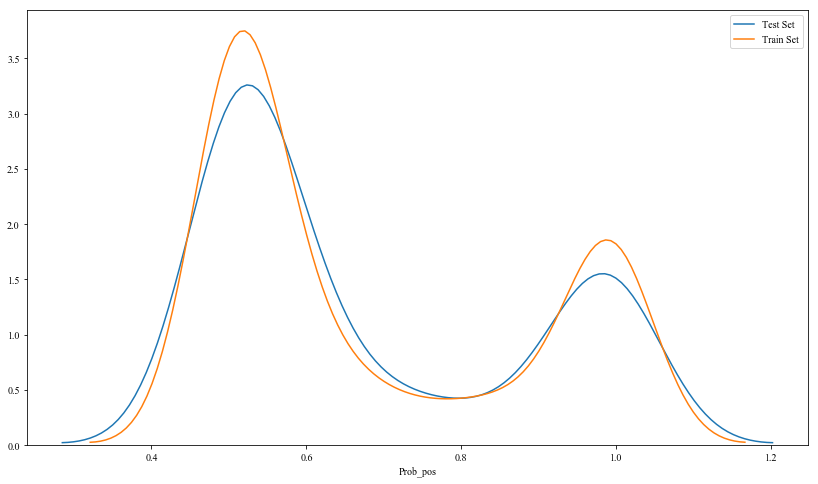

In [12]:
fig = plt.figure(figsize=(14, 8))
sns.distplot(labels_with_pred[labels_with_pred.testing_set].Prob_pos, hist=False, label='Test Set')
sns.distplot(labels_with_pred[labels_with_pred.training_set].Prob_pos, hist=False, label='Train Set')

## Train other Classifiers on the Features for Comparison
In order to evaluate our method, let's compare it's power to other algorithms. For now, I'll focus on ones, that operate on the features alone and algorithms that operate on the network alone.
The comparison is with:
* **SVM classifier**: A very powerful, non-linear method that generally does not really overfit and can deal with little data. This should be an upper bound on what one can reach on the features alone.
* **Logistic regression**: This is a linear algorithm, also only operating on the features. It is less powerful than an SVM.
* **PageRank**: A network ranking method that only computes the most important nodeso in the network. It's completely blind to the features.

Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt
Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt
Number of predicted genes in Test set (RF): 37
RF predicts 576 genes in total
Number of predicted genes in Test set (LogReg): 31
LogReg predicts 273 genes in total
Maximum Pagerank: Index: 11270	Pagerank: 0.006650312418214648
Minimum Pagerank: Index: 3508	Pagerank: 1.503088157884692e-05


/pkg/python-3.6.0-0/lib/python3.6/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


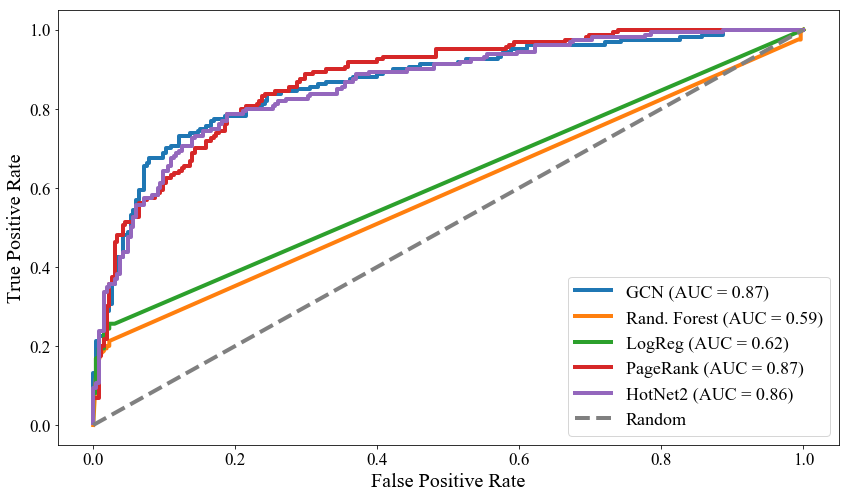

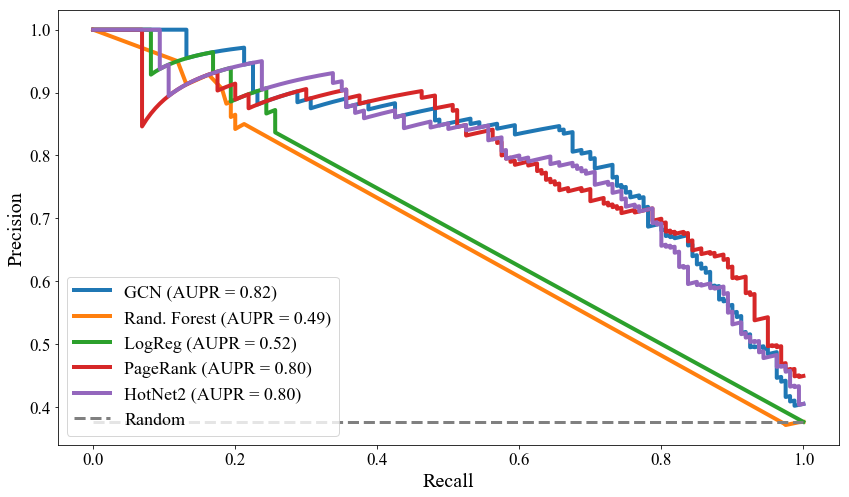

In [127]:
best_thr_roc, best_thr_pr = postprocessing.compute_ROC_PR_competitors(model_dir)

## Compute Overlap with other Datasets

Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt


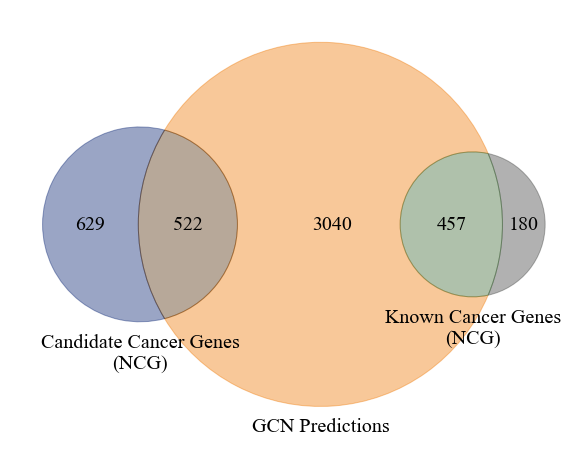

In [128]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

remove_blood_cancer_genes = False
if remove_blood_cancer_genes:
    # load cgc
    cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
    cgc.dropna(subset=['Tissue Type'], inplace=True)

    # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
    pattern = '|'.join(['E', 'O', 'M', 'E;'])
    non_blood_cancer_genes = cgc[cgc['Tissue Type'].str.contains(pattern)]
    blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
    known_cancer_genes_innet = non_blood_cancer_genes[non_blood_cancer_genes['Gene Symbol'].isin(known_cancer_genes_innet)]['Gene Symbol']
    print ("Left with {} known cancer genes after blood removal".format(known_cancer_genes_innet.shape[0]))

postprocessing.compute_overlap(model_dir, 'overlap_NCG.svg',
                               known_cancer_genes_innet, candidate_cancer_genes_innet,
                               best_thr_pr,
                               ['Known Cancer Genes\n(NCG)', 'Candidate Cancer Genes\n(NCG)']
                              )

Hyper-Parameters read from ../data/GCN/training/2019_04_26_15_21_21/mutations/hyper_params.txt


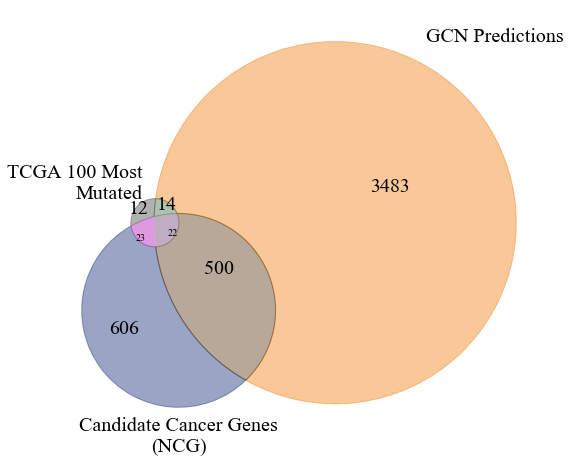

In [130]:
tcga_most_mut = pd.read_csv('../data/pancancer/TCGA/tcga_100_most_mutated_genes.tsv', sep='\t')
tcga_most_mut.drop('Select column', axis=1, inplace=True)
tcga_most_mut.set_index('Symbol', inplace=True)
tcga_most_mut_innet = tcga_most_mut[tcga_most_mut.index.isin(node_names[:, 1])]
postprocessing.compute_overlap(model_dir, 'overlap_TCGA_most_mutated.svg',
                               tcga_most_mut_innet.index, candidate_cancer_genes_innet,
                               best_thr_pr,
                               ['TCGA 100 Most\nMutated', 'Candidate Cancer Genes\n(NCG)']
                              )

## List of Potential **New** Disease Genes according to the model

In [98]:
all_ncg_genes = known_cancer_genes + candidate_cancer_genes
not_labeled = ensemble_predictions[~ensemble_predictions.Name.isin(known_cancer_genes)]
cols_of_interest = ['Name', 'label', 'Num_Pos', 'Mean_Pred', 'Std_Pred']
not_labeled[not_labeled.Name.isin(candidate_cancer_genes)].sort_values(by='Mean_Pred', ascending=False)[cols_of_interest].head(10)

,Name,label,Num_Pos,Mean_Pred,Std_Pred
ID,,,,,
ENSG00000143878,RHOB,False,10,1.000,0.000
ENSG00000132522,GPS2,False,10,1.000,0.000
ENSG00000196591,HDAC2,False,10,1.000,0.000
ENSG00000185650,ZFP36L1,False,10,1.000,0.000
ENSG00000230985,VARS2,False,10,1.000,0.000
ENSG00000055957,ITIH1,False,10,1.000,0.000
ENSG00000078900,TP73,False,10,1.000,0.000
ENSG00000153487,ING1,False,10,1.000,0.000
ENSG00000169375,SIN3A,False,10,1.000,0.000
